In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import os
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

         image_id  label
0  1000015157.jpg      0
1  1000201771.jpg      3
2   100042118.jpg      1
3  1000723321.jpg      1
4  1000812911.jpg      3
0    1000015157.jpg
1    1000201771.jpg
2     100042118.jpg
3    1000723321.jpg
4    1000812911.jpg
Name: image_id, dtype: object


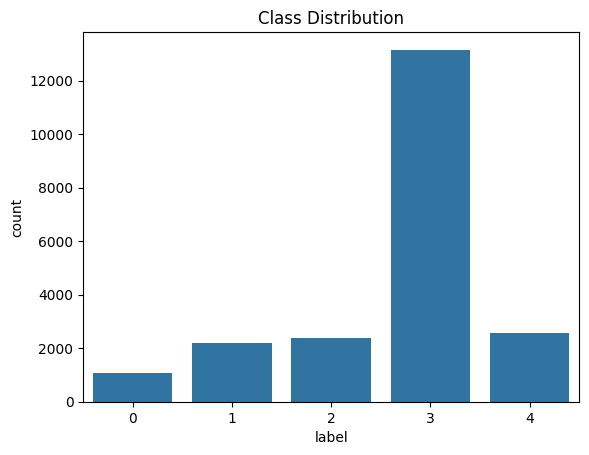

In [3]:
# Define dataset paths
dataset_path = "/content/drive/MyDrive/cassava_dataset"
image_folder = os.path.join(dataset_path, "train_images")
csv_file = os.path.join(dataset_path, "train.csv")

# Load CSV file
df = pd.read_csv(csv_file)


# Check the first few rows
print(df.head())

print(df['image_id'].head())  # Check the first few filenames

# Check class distribution
sns.countplot(x=df['label'])
plt.title("Class Distribution")
plt.show()


In [5]:

image_folder = "/content/drive/MyDrive/cassava_dataset/train_images"

if os.path.exists(image_folder):
    print("Image folder exists")
    print("Sample images in directory:", os.listdir(image_folder)[:10])  # Show first 10 images
else:
    print("Image folder does NOT exist! Check your Google Drive path.")

print(os.listdir(image_folder)[:10])  # Show the first 10 image names


Image folder exists
Sample images in directory: ['805835204.jpg', '808870213.jpg', '807190211.jpg', '80998969.jpg', '807555228.jpg', '806670613.jpg', '808606006.jpg', '804903970.jpg', '809489252.jpg', '807063038.jpg']
['805835204.jpg', '808870213.jpg', '807190211.jpg', '80998969.jpg', '807555228.jpg', '806670613.jpg', '808606006.jpg', '804903970.jpg', '809489252.jpg', '807063038.jpg']


In [6]:


# Define paths
csv_path = "/content/drive/MyDrive/cassava_dataset/train.csv"
image_folder = "/content/drive/MyDrive/cassava_dataset/train_images"

# Load train.csv
df = pd.read_csv(csv_path)

# Get lists of image names
csv_images = set(df['image_id'])  # Images listed in CSV
folder_images = set(os.listdir(image_folder))  # Images in train_images folder

# Identify missing and extra images
missing_images = csv_images - folder_images  # In CSV but not in folder
extra_images = folder_images - csv_images  # In folder but not in CSV

# Print results
print(f"Total images in CSV: {len(csv_images)}")
print(f"Total images in folder: {len(folder_images)}")
print(f"Missing images (in CSV but not in folder): {len(missing_images)}")
print(f"Extra images (in folder but not in CSV): {len(extra_images)}")


Total images in CSV: 21397
Total images in folder: 17938
Missing images (in CSV but not in folder): 3459
Extra images (in folder but not in CSV): 0


In [7]:
# Remove rows in df where images are missing
df = df[~df['image_id'].isin(missing_images)]

# Save cleaned CSV (optional, for future use)
cleaned_csv_path = "/content/drive/MyDrive/cassava_dataset/train_cleaned.csv"
df.to_csv(cleaned_csv_path, index=False)

print(f"Updated dataset size: {len(df)}")


Updated dataset size: 17938


In [8]:
for img in extra_images:
    img_path = os.path.join(image_folder, img)
    os.remove(img_path)  # Delete extra image

print("Extra images removed successfully!")


Extra images removed successfully!


In [9]:
import os
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Define constants
IMG_SIZE = 224
BATCH_SIZE = 32


# Define paths
dataset_path = "/content/drive/MyDrive/cassava_dataset"
csv_path = os.path.join(dataset_path, "train.csv")
image_folder = os.path.join(dataset_path, "train_images")

# Load dataset
df = pd.read_csv(csv_path)

# Get actual image filenames from the folder
available_images = set(os.listdir(image_folder))

# Remove rows where images are missing
df = df[df['image_id'].isin(available_images)].reset_index(drop=True)

# Print dataset stats
print(f"Total images in CSV (after cleaning): {len(df)}")
print(f"Total images available in folder: {len(available_images)}")


# Function to preprocess images
def preprocess_image(img_path):
    try:
        img = cv2.imread(img_path)
        if img is None:
            raise Exception("Corrupt Image")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert BGR to RGB
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) # Resize to 224x224
        img = img / 255.0  # Normalize pixel values to [0,1]
        return img
    except:
        print(f"Warning: Could not read image {img_path}")
        return np.zeros((IMG_SIZE, IMG_SIZE, 3))  # Return blank image

# Split dataset into train, validation, test
df_train, df_temp = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
df_val, df_test = train_test_split(df_temp, test_size=0.5, stratify=df_temp['label'], random_state=42)



Total images in CSV (after cleaning): 17938
Total images available in folder: 17938


In [10]:
# Define Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,          # Normalize pixel values
    rotation_range=30,       # Random rotation (0-30 degrees)
    width_shift_range=0.2,   # Horizontal shift (up to 20% of width)
    height_shift_range=0.2,  # Vertical shift (up to 20% of height)
    shear_range=0.2,         # Shearing transformation (distorts shape)
    zoom_range=0.2,          # Random zoom
    horizontal_flip=True,    # Randomly flip images horizontally
    fill_mode='nearest'      # Fill missing pixels after transformation
)

#Validation & Test Preprocessing
val_datagen = ImageDataGenerator(rescale=1./255)  # Only rescaling for validation & test

# Convert 'label' column to string type
df_train['label'] = df_train['label'].astype(str)
df_val['label'] = df_val['label'].astype(str)
df_test['label'] = df_test['label'].astype(str)

# Create Data Generators
#train generator(with augumentation)
train_generator = train_datagen.flow_from_dataframe(
    df_train, directory=image_folder, x_col="image_id", y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode="sparse"
)

#Validation Generator-Only rescales images (no augmentation)
val_generator = val_datagen.flow_from_dataframe(
    df_val, directory=image_folder, x_col="image_id", y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode="sparse"
)

#Test Generator (For Final Evaluation)
test_generator = val_datagen.flow_from_dataframe(
    df_test, directory=image_folder, x_col="image_id", y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode="sparse",
    shuffle=False  # No need to shuffle test data
)

# Print dataset sizes
print(f"Train size: {len(df_train)}, Validation size: {len(df_val)}, Test size: {len(df_test)}")
print(" Data preprocessing & augmentation completed successfully!")


Found 12556 validated image filenames belonging to 5 classes.
Found 2691 validated image filenames belonging to 5 classes.
Found 2691 validated image filenames belonging to 5 classes.
Train size: 12556, Validation size: 2691, Test size: 2691
 Data preprocessing & augmentation completed successfully!


In [ ]:
#correct code take 1 hr to run single epoch

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping


# Define custom CNN model
def build_custom_cnn(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=len(df['label'].unique())):
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2,2)),

        Conv2D(64, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2,2)),

        Conv2D(128, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2,2)),

        Conv2D(256, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2,2)),

        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')  # Multi-class classification
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

    return model

# Create model
model = build_custom_cnn()
model.summary()

# Define callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_loss", mode="min"),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, verbose=1, mode="min"),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, verbose=1, restore_best_weights=True)
]

# Train model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=callbacks
)

# Evaluate model on test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Save final model
model.save("cassava_custom_cnn.h5")
print("Model saved successfully!")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 28, 28, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      25,690,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,213,573 (100.00 MB)

 Trainable params: 26,212,613 (99.99 MB)

 Non-trainable params: 960 (3.75 KB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.4545 - loss: 10.4891 

393/393 ━━━━━━━━━━━━━━━━━━━━ 4821s 12s/step - accuracy: 0.4546 - loss: 10.4760 - val_accuracy: 0.6150 - val_loss: 1.3166 - learning_rate: 0.0010
Epoch 2/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.5965 - loss: 1.2942

393/393 ━━━━━━━━━━━━━━━━━━━━ 3851s 10s/step - accuracy: 0.5965 - loss: 1.2942 - val_accuracy: 0.6150 - val_loss: 1.0810 - learning_rate: 0.0010
Epoch 3/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3847s 10s/step - accuracy: 0.6130 - loss: 1.1635 - val_accuracy: 0.6150 - val_loss: 1.1170 - learning_rate: 0.0010
Epoch 4/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.6130 - loss: 1.1206

393/393 ━━━━━━━━━━━━━━━━━━━━ 3832s 10s/step - accuracy: 0.6130 - loss: 1.1205 - val_accuracy: 0.6150 - val_loss: 1.0173 - learning_rate: 0.0010
Epoch 5/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3865s 10s/step - accuracy: 0.6263 - loss: 1.0604 - val_accuracy: 0.5084 - val_loss: 1.4491 - learning_rate: 0.0010
Epoch 6/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3826s 10s/step - accuracy: 0.6046 - loss: 1.0845 - val_accuracy: 0.6150 - val_loss: 1.1687 - learning_rate: 0.0010
Epoch 7/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.6149 - loss: 1.0550
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
393/393 ━━━━━━━━━━━━━━━━━━━━ 3818s 10s/step - accuracy: 0.6149 - loss: 1.0550 - val_accuracy: 0.6150 - val_loss: 1.3814 - learning_rate: 0.0010
Epoch 8/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3818s 10s/step - accuracy: 0.6212 - loss: 0.9946 - val_accuracy: 0.6150 - val_loss: 1.1759 - learning_rate: 2.0000e-04
Epoch 9/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3872s 10s/step - accuracy: 0.6195 - loss:

Test Accuracy: 61.46%
Model saved successfully!


In [3]:
# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined

In [ ]:
#Compare performance metrics such as accuracy, precision, recall, and F1-score.
#Apply hyperparameter tuning to improve performance.

#Model evaluation
#Evaluate the trained models on the test set.
#Compare results and choose the best-performing model.
#Perform error analysis and discuss potential improvements.

#Deployment & User Interface Development
#Build a web-based or desktop application for disease detection.
#Implement an image upload feature to classify new images.
#Use Flask, FastAPI, or Streamlit for backend development.
#Deploy the model using cloud services (e.g., AWS, Google Cloud) or as a local application.


In [ ]:
#Compare performance metrics such as accuracy, precision, recall, and F1-score.

In [ ]:
#code to compare performance metrix

85/85 ━━━━━━━━━━━━━━━━━━━━ 185s 2s/step - accuracy: 0.6193 - loss: 1.0199
Test Accuracy: 61.46%
85/85 ━━━━━━━━━━━━━━━━━━━━ 166s 2s/step
Precision: 0.3778
Recall: 0.6146
F1-Score: 0.4679
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       138
           1       0.00      0.00      0.00       275
           2       0.00      0.00      0.00       299
           3       0.61      1.00      0.76      1654
           4       0.00      0.00      0.00       325

    accuracy                           0.61      2691
   macro avg       0.12      0.20      0.15      2691
weighted avg       0.38      0.61      0.47      2691

Confusion Matrix:
[[   0    0    0  138    0]
 [   0    0    0  275    0]
 [   0    0    0  299    0]
 [   0    0    0 1654    0]
 [   0    0    0  325    0]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

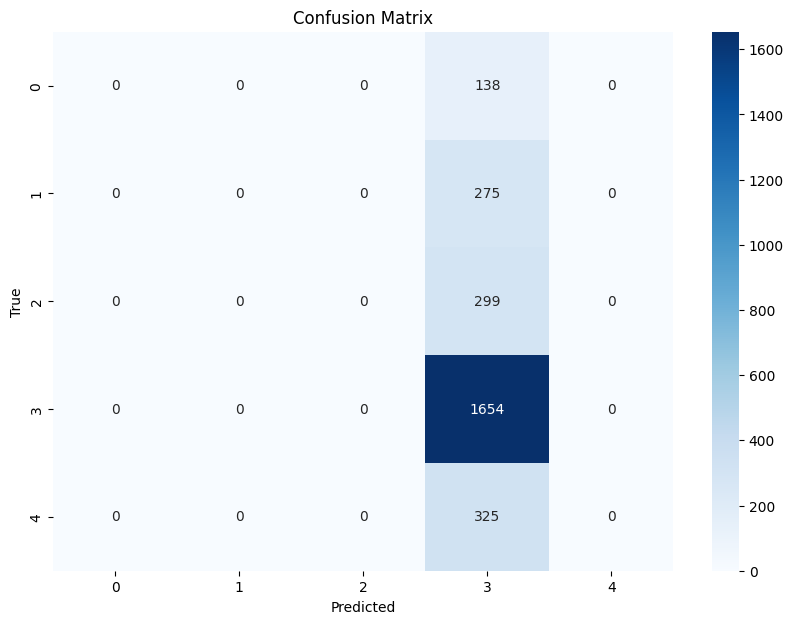

In [14]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate model on test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Get predictions
y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels
y_true = test_generator.classes  # True labels

# Compute precision, recall, and F1-score
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Generate a classification report
class_names = list(test_generator.class_indices.keys())
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Generate a confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping


# Define custom CNN model
def build_custom_cnn(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=len(df['label'].unique())):
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2,2)),

        Conv2D(64, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2,2)),

        Conv2D(128, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2,2)),

        Conv2D(256, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2,2)),

        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')  # Multi-class classification
    ])

    # Freeze all convolutional layers
    for layer in model.layers[:-5]:  # Freeze all layers except the last 5 (dense layers)
        layer.trainable = False

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

    return model

# Create model
model = build_custom_cnn()
model.summary()

# Define callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_loss", mode="min"),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, verbose=1, mode="min"),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, verbose=1, restore_best_weights=True)
]

# Train the top layers
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,  # Train for fewer epochs initially
    callbacks=callbacks
)


# Unfreeze some of the convolutional layers
for layer in model.layers[:-8]:  # Unfreeze all layers except the last 8 (last 2 conv blocks + dense layers)
    layer.trainable = True

# Recompile the model with a smaller learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Smaller learning rate for fine-tuning
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# Fine-tune the model
history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,  # Train for additional epochs
    callbacks=callbacks
)


# Evaluate model on test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy after Fine-Tuning: {test_acc * 100:.2f}%")

# Save final model
model.save("cassava_custom_cnn_finetuned.h5")
print("Fine-Tuned Model saved successfully!")